In [36]:
import pandas as pd
from datetime import datetime

In [37]:
directory='/home/tanmay/sales forecasting project/dataset/Sales - Monthly (Millions of Dollars).csv'
df=pd.read_csv(directory)
df.columns=["Months","Sales"]
#sales in millions

In [38]:
#removing irrelvant rows
df = df.dropna()

#changing dateTime format
df['Months']=pd.to_datetime(df['Months'], dayfirst=True)



In [39]:
df

,Months,Sales
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068
...,...,...
334,2019-11-01,535352
335,2019-12-01,591380
336,2020-01-01,481862
337,2020-02-01,479868


In [40]:
df.tail(20)

,Months,Sales
319,2018-08-01,521962
320,2018-09-01,478595
321,2018-10-01,505194
322,2018-11-01,520956
323,2018-12-01,559289
324,2019-01-01,458089
325,2019-02-01,443708
326,2019-03-01,515694
327,2019-04-01,509413
328,2019-05-01,547130


In [41]:
df.set_index("Months", inplace=True)
df

,Sales
Months,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068
...,...
2019-11-01,535352
2019-12-01,591380
2020-01-01,481862


<AxesSubplot: xlabel='Months'>

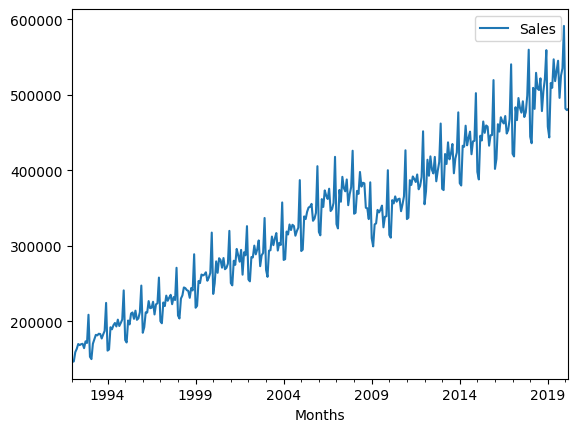

In [42]:
df.plot()

In [43]:
from statsmodels.tsa.stattools import adfuller

In [44]:
res=adfuller(df['Sales'])
res
#if p-value(2nd row of outpt)<=0.05 then stationary else not-stationary
#therefore not-stationary
#its also visible from the plot above

(-0.4699769065426257,
 0.8977433449541786,
 15,
 323,
 {'1%': -3.4507587628808922,
  '5%': -2.870530068560499,
  '10%': -2.5715597727381647},
 6696.435845589347)

So how to make it stationary:

1. Differecing

In [45]:
# df['Sales'].shift(1)  #this will shift one value down

df['Sales 1st diff']=df['Sales']-df['Sales'].shift(1)

#but as seen from the plot the data is seasonal, so instead of shifting it just once will we shift it by one year
#that is 12 months threfore:
df['Seasonal diff']=df['Sales']-df['Sales'].shift(12)

In [46]:
#so now again running the stationary test on the seasonal differenced data
res=adfuller(df['Seasonal diff'].dropna()) #dropna is used to exclude the rows with NaN values
res
#so here the p-val=2.0605796968136632e-11 which is <0.05 therefore its stationary

(-3.5002505292478685,
 0.007980662270419563,
 15,
 311,
 {'1%': -3.451552879535732,
  '5%': -2.8708786756338407,
  '10%': -2.571745666091128},
 6412.434813688588)

<AxesSubplot: xlabel='Months'>

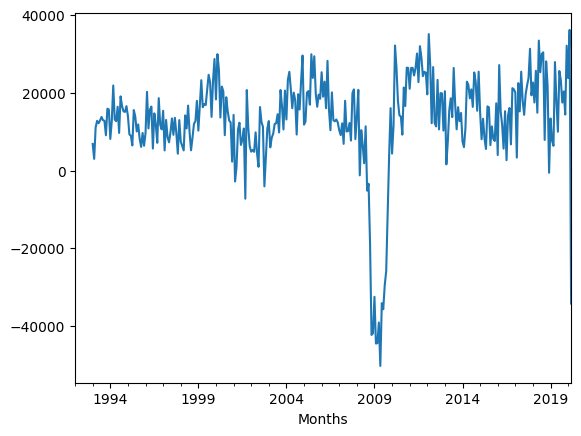

In [47]:
df['Seasonal diff'].plot()
#this also looks stationary

Now we will do auto correlation: it is used to determine that how much lag we will have to use to do the predictoins successfully
ie. how much prev data will be required to make successful predictions

in ARIMA model there are 3 values:
1.  p:AR model lags
2.  d: differencing
3.  q: MA model lags 

I in ARIMA stands for differencing, so if we don't difference the model then its simply ARMA model
AR is often done best with PACF(partial auto correlation function)

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm

Now to know how many lags should we consider, we use pacf:
1. the below graph has pacf as y axis and lags as x axis

/home/tanmay/.local/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


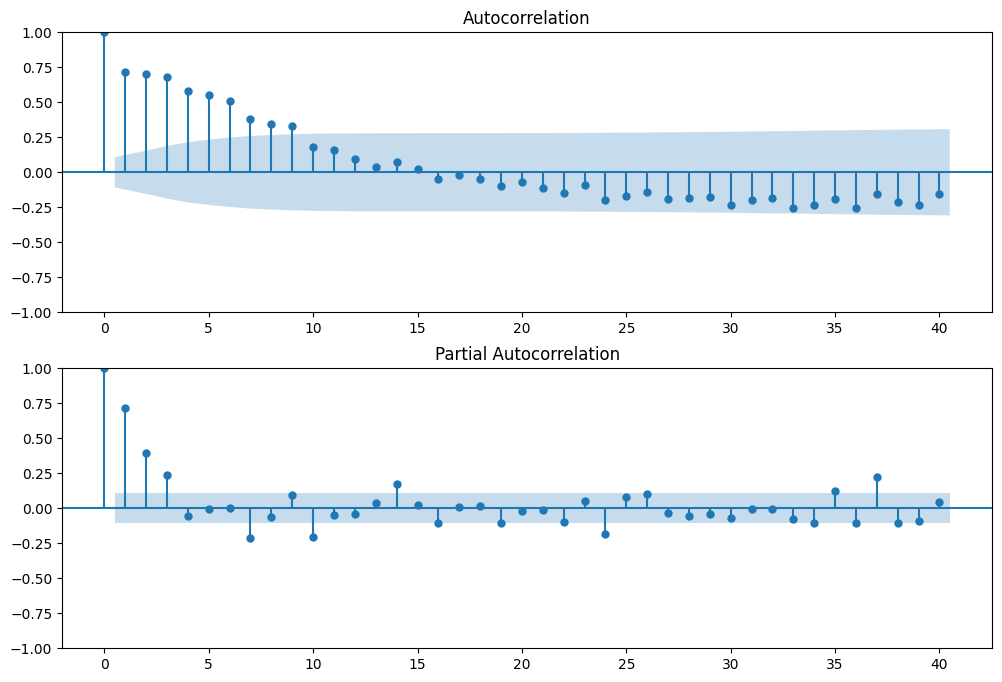

In [49]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_acf(df['Seasonal diff'].dropna(),lags=40,ax=ax1)
fig=sm.graphics.tsa.plot_pacf(df['Seasonal diff'].dropna(),lags=40,ax=ax2)

the blue area is the significance line, so the lags above the sgnificance lines tells the value of p or q depending on the graph:
1. the pacf graph will tell p value (here its 2 approx)
1. the acf graph will tell q value (here its 1)

In [50]:
from statsmodels.tsa.arima.model import ARIMA


In [51]:


model = ARIMA(df['Sales'], order=(2,1,1)) #p=2, q=1, d=1
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  339
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3916.994
Date:                Sat, 21 Jan 2023   AIC                           7841.987
Time:                        18:37:55   BIC                           7857.279
Sample:                    01-01-1992   HQIC                          7848.082
                         - 03-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.078     -0.847      0.397      -0.218       0.087
ar.L2         -0.2545      0.068     -3.733      0.000      -0.388      -0.121
ma.L1         -0.7360      0.063    -11.682      0.0

/home/tanmay/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tanmay/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tanmay/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot: xlabel='Months'>

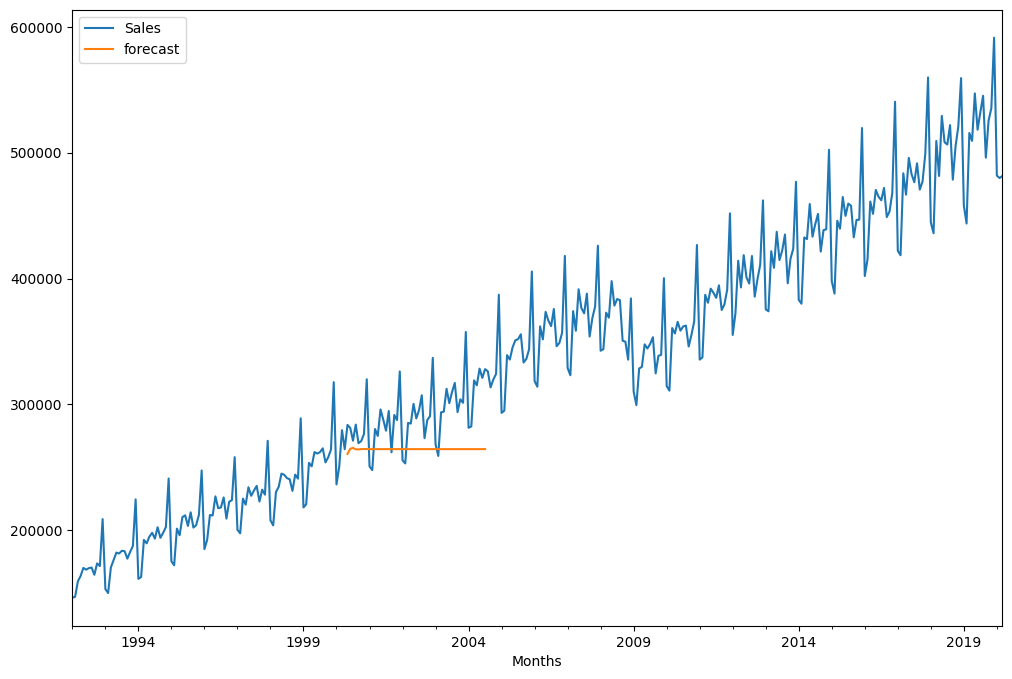

In [52]:
df['forecast']=model_fit.predict(start=100,end=150,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

since the normal arima is doing very poor predictions, we need to do SARIMA for seasonal data

In [53]:

model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(2, 1, 1),seasonal_order=(2,1,1,12))
results=model.fit()


/home/tanmay/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tanmay/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03510D+01    |proj g|=  7.66222D-01

At iterate    5    f=  1.00642D+01    |proj g|=  5.03266D-03

At iterate   10    f=  1.00639D+01    |proj g|=  1.34423D-03

At iterate   15    f=  1.00639D+01    |proj g|=  2.68056D-03

At iterate   20    f=  1.00639D+01    |proj g|=  1.45777D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     24      1     0     0   1.119D-05   1.006D+01
  F =   10.063895788706008     

CONVERG

<AxesSubplot: xlabel='Months'>

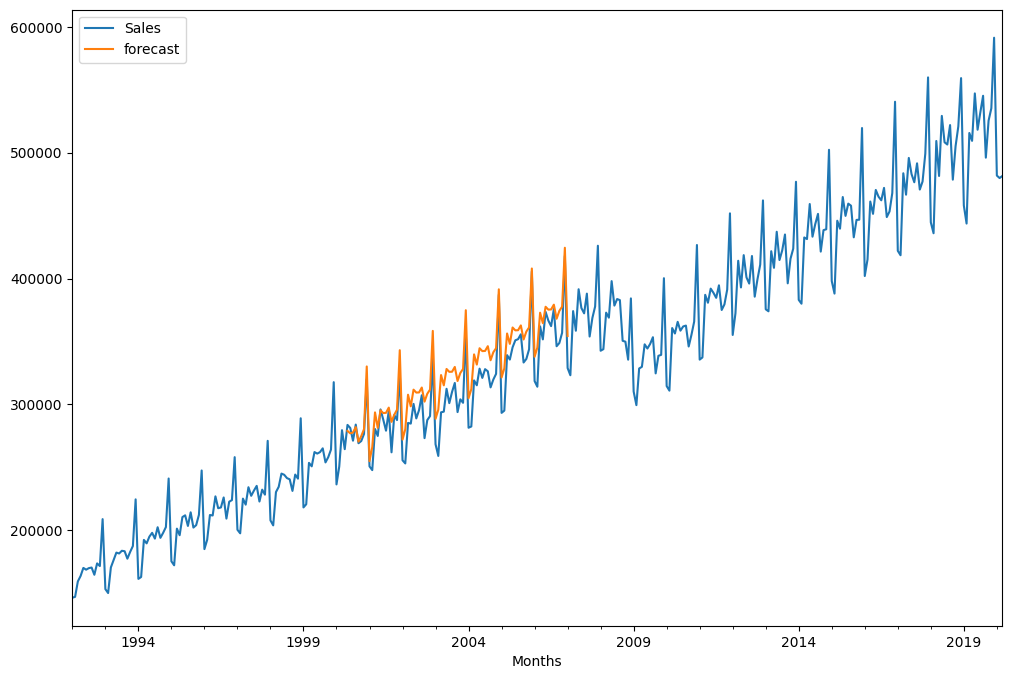

In [54]:
#here start is the starting index from where we want to start the prediction from
df['forecast']=results.predict(start=100,end=180,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

Accuracy check:

In [55]:
tst=df['Sales'].iloc[99:180]
pred=df['forecast'].dropna()

In [56]:
pred.dropna()

Months
2000-05-01    278927.651537
2000-06-01    277010.666003
2000-07-01    277673.526573
2000-08-01    281968.654531
2000-09-01    270448.294160
                  ...      
2006-09-01    368066.622990
2006-10-01    374346.707201
2006-11-01    377653.405873
2006-12-01    424486.221415
2007-01-01    354341.174243
Name: forecast, Length: 81, dtype: float64

In [57]:
import numpy as np

In [58]:
def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(pred, tst)

/tmp/ipykernel_10840/1939603450.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
/tmp/ipykernel_10840/1939603450.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)


{'me': 15198.938717995707,
 'mae': 15491.972693793767,
 'mpe': 0.049868303813900484,
 'rmse': 17778.641479118178,
 'corr': 0.6414267281320064,
 'minmax': 0.08108928713926145}

since the Mean percentage error is aprox. 5% so accuracy is 95%

_____________________________________________________________________________________________________________________

Now doing Predictions

so now to do future pridiction we need to extend the df to few dates ahead with null values which then will be filled with the predicted values

In [59]:
from pandas.tseries.offsets import DateOffset
#creating extra indexes
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]



In [60]:
#creating df using the extra indexes
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df


,Sales,Sales 1st diff,Seasonal diff,forecast
2020-04-01,NaN,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN,NaN
2020-08-01,NaN,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN,NaN
2020-11-01,NaN,NaN,NaN,NaN
2020-12-01,NaN,NaN,NaN,NaN
2021-01-01,NaN,NaN,NaN,NaN


In [61]:
df.tail

<bound method NDFrame.tail of              Sales  Sales 1st diff  Seasonal diff  forecast
Months                                                     
1992-01-01  146376             NaN            NaN       NaN
1992-02-01  147079           703.0            NaN       NaN
1992-03-01  159336         12257.0            NaN       NaN
1992-04-01  163669          4333.0            NaN       NaN
1992-05-01  170068          6399.0            NaN       NaN
...            ...             ...            ...       ...
2019-11-01  535352          9813.0        14396.0       NaN
2019-12-01  591380         56028.0        32091.0       NaN
2020-01-01  481862       -109518.0        23773.0       NaN
2020-02-01  479868         -1994.0        36160.0       NaN
2020-03-01  481513          1645.0       -34181.0       NaN

[339 rows x 4 columns]>

In [62]:
# now concatinating that extra df with the original df
future_df=pd.concat([df,future_datest_df])

<AxesSubplot: >

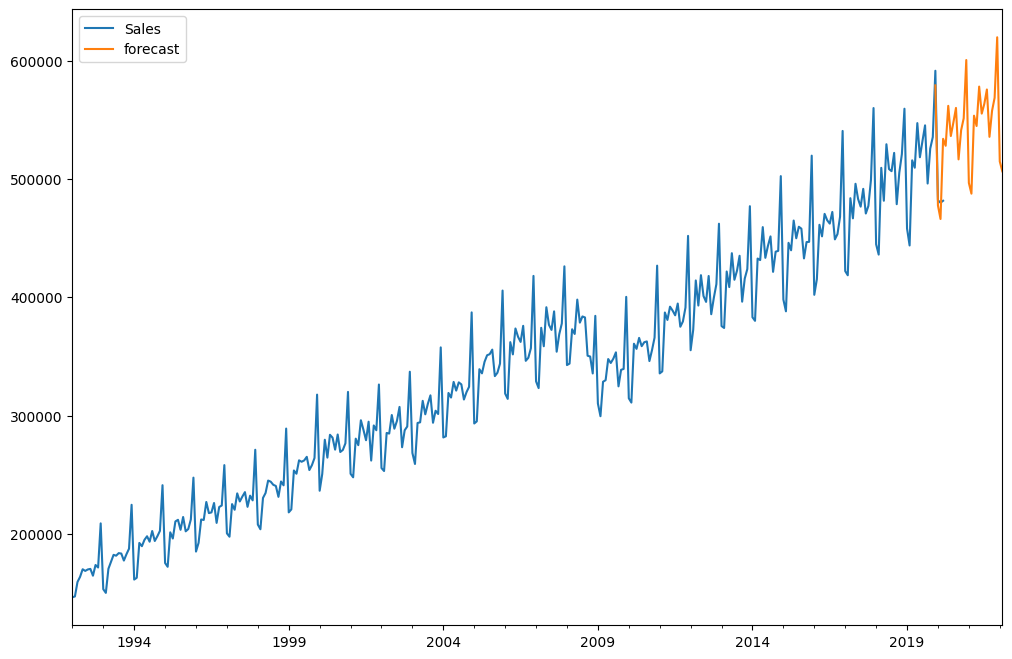

In [63]:
#now doing the future predictions
future_df['forecast'] = results.predict(start = 335, end = 500, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 

In [64]:
future_df['forecast']

1992-01-01              NaN
1992-02-01              NaN
1992-03-01              NaN
1992-04-01              NaN
1992-05-01              NaN
                  ...      
2021-10-01    557501.715872
2021-11-01    568539.540200
2021-12-01    619675.189152
2022-01-01    514738.546868
2022-02-01    506374.167803
Name: forecast, Length: 362, dtype: float64